In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# Load dataset
df = pd.read_csv("magic04data")
df.head()

,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828,g
0,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.261,g
1,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.788,g
2,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.737,g
3,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.462,g
4,51.6240,21.1502,2.9085,0.2420,0.1340,50.8761,43.1887,9.8145,3.6130,238.098,g


In [3]:
# Assign column names (as per dataset description)
columns = [
    "fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", 
    "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"
]
df.columns = columns

In [4]:
# Convert class labels ("g" = 1, "h" = 0)
df["class"] = df["class"].map({"g": 1, "h": 0})

# Handle class imbalance: Reduce "g" class to match "h" count
hadron_count = df[df["class"] == 0].shape[0]
gamma_sample = df[df["class"] == 1].sample(n=hadron_count, random_state=42)


In [5]:
# Merge balanced dataset
df_balanced = pd.concat([df[df["class"] == 0], gamma_sample]).sample(frac=1, random_state=42)

# Split features & target variable
X = df_balanced.drop(columns=["class"])
y = df_balanced["class"]

# Split dataset (70% train, 15% validation, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Normalize data (K-NN requires feature scaling)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [6]:
# Function to train and evaluate K-NN with different k values
def evaluate_knn():
    results = []
    for k in range (1,35,1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        # Predict on validation set
        y_pred = knn.predict(X_val)

        # Compute metrics
        accuracy = accuracy_score(y_val, y_pred)
        report = classification_report(y_val, y_pred, output_dict=True)
        precision, recall, f1_score = report["1"]["precision"], report["1"]["recall"], report["1"]["f1-score"]

        results.append((k, accuracy, precision, recall, f1_score))
        print(f"\nK={k} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1_score:.4f}")

        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        print("Confusion Matrix:\n", cm)

    return results

In [8]:
# Try different K values

results = evaluate_knn()

# Find best K
best_k = max(results, key=lambda x: x[1])[0]
print(f"\nBest K-value: {best_k}")

# Train final model with best K and evaluate on test set
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(X_train, y_train)
y_test_pred = final_knn.predict(X_test)

# Test set performance
print("\nFinal Model Performance on Test Set:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


K=1 | Accuracy: 0.7891 | Precision: 0.7613 | Recall: 0.8425 | F1-score: 0.7998
Confusion Matrix:
 [[738 265]
 [158 845]]

K=2 | Accuracy: 0.7737 | Precision: 0.8173 | Recall: 0.7049 | F1-score: 0.7570
Confusion Matrix:
 [[845 158]
 [296 707]]

K=3 | Accuracy: 0.8026 | Precision: 0.7698 | Recall: 0.8634 | F1-score: 0.8139
Confusion Matrix:
 [[744 259]
 [137 866]]

K=4 | Accuracy: 0.7991 | Precision: 0.8000 | Recall: 0.7976 | F1-score: 0.7988
Confusion Matrix:
 [[803 200]
 [203 800]]

K=5 | Accuracy: 0.8056 | Precision: 0.7677 | Recall: 0.8764 | F1-score: 0.8184
Confusion Matrix:
 [[737 266]
 [124 879]]

K=6 | Accuracy: 0.8056 | Precision: 0.7927 | Recall: 0.8275 | F1-score: 0.8098
Confusion Matrix:
 [[786 217]
 [173 830]]

K=7 | Accuracy: 0.8056 | Precision: 0.7658 | Recall: 0.8804 | F1-score: 0.8191
Confusion Matrix:
 [[733 270]
 [120 883]]

K=8 | Accuracy: 0.8126 | Precision: 0.7879 | Recall: 0.8554 | F1-score: 0.8203
Confusion Matrix:
 [[772 231]
 [145 858]]

K=9 | Accuracy: 0.8136 

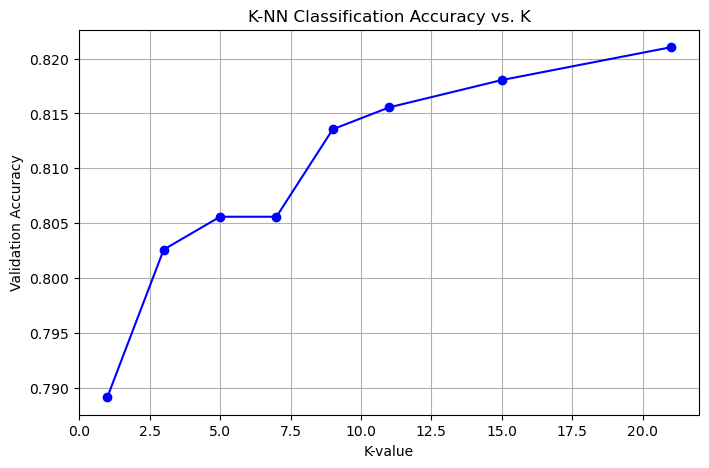

In [32]:
# Plot Accuracy vs. K-values
plt.figure(figsize=(8, 5))
plt.plot([x[0] for x in results], [x[1] for x in results], marker="o", linestyle="-", color="b")
plt.xlabel("K-value")
plt.ylabel("Validation Accuracy")
plt.title("K-NN Classification Accuracy vs. K")
plt.grid()
plt.show()